导入必要库

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
from sklearn.datasets import load_files
from sklearn.preprocessing import StandardScaler
import numpy as np
from skimage.transform import resize  # 添加了resize函数

BPNN模型：增加了批量归一化处理，让训练速度加快

In [6]:
# 定义Sigmoid激活函数
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

# 定义Sigmoid导数函数
def sigmoid_derivative(x):
    return x * (1 - x)

# 定义批量归一化函数
def batch_norm(X, gamma, beta, epsilon=1e-5):
    mean = np.mean(X, axis=0)
    variance = np.var(X, axis=0)
    X_norm = (X - mean) / np.sqrt(variance + epsilon)
    out = gamma * X_norm + beta
    return out, mean, variance

# 定义BPNN模型
class BPNN:
    def __init__(self, layers, alpha=0.001, epochs=500, batch_size=32):
        self.layers = layers
        self.alpha = alpha
        self.epochs = epochs
        self.batch_size = batch_size
        self.weights = []
        self.biases = []
        self.gamma = []
        self.beta = []
        self.losses = []

        # 初始化权重、偏置、gamma（缩放因子）和beta（偏移因子）
        for i in range(1, len(layers)):
            self.weights.append(2 * np.random.random((layers[i-1], layers[i])) - 1)
            self.biases.append(np.zeros((1, layers[i])))
            self.gamma.append(np.ones((1, layers[i])))
            self.beta.append(np.zeros((1, layers[i])))

    # 训练模型
    def fit(self, X, y):
        for epoch in range(self.epochs):
            for i in range(0, X.shape[0], self.batch_size):
                X_batch = X[i:i+self.batch_size]
                y_batch = y[i:i+self.batch_size]
                self.train(X_batch, y_batch)
            loss = np.mean(np.square(y - self.predict(X)))
            self.losses.append(loss)
            print(f"Iteration {epoch + 1}, loss = {loss:.8f}")

    # 单次训练过程
    def train(self, X, y):
        activations = [X]
        batch_norm_params = []

        # 前向传播
        for i in range(len(self.weights)):
            net = np.dot(activations[-1], self.weights[i]) + self.biases[i]
            # 应用批量归一化
            net, mean, variance = batch_norm(net, self.gamma[i], self.beta[i])
            batch_norm_params.append((mean, variance))
            out = sigmoid(net)  # 修正了这里的函数调用
            activations.append(out)

        y_error = np.eye(self.layers[-1])[y]
        # 计算误差
        error = activations[-1] - y_error

        # 反向传播
        deltas = [error * sigmoid_derivative(activations[-1])]
        for i in reversed(range(len(self.weights) - 1)):
            delta = deltas[-1].dot(self.weights[i + 1].T) * sigmoid_derivative(activations[i + 1])
            deltas.append(delta)
        deltas.reverse()

        # 更新权重和偏置
        for i in range(len(self.weights)):
            self.weights[i] -= self.alpha * activations[i].T.dot(deltas[i])
            self.biases[i] -= self.alpha * np.sum(deltas[i], axis=0, keepdims=True)
            # 更新gamma和beta参数
            self.gamma[i] -= self.alpha * np.sum(
                deltas[i] * (activations[i + 1] - batch_norm_params[i][0]) / np.sqrt(batch_norm_params[i][1] + 1e-5),
                axis=0)
            self.beta[i] -= self.alpha * np.sum(deltas[i], axis=0)

    # 预测
    def predict(self, X):
        activations = [X]
        for i in range(len(self.weights)):
            net = np.dot(activations[-1], self.weights[i]) + self.biases[i]
            # 应用批量归一化
            net, _, _ = batch_norm(net, self.gamma[i], self.beta[i])
            out = sigmoid(net)
            activations.append(out)
        return np.argmax(activations[-1], axis=1)


数据处理，特征提取，特征缩放

In [7]:
def load_dataset(path):
    data = load_files(path)
    files = np.array(data['filenames'])
    targets = np.array(data['target'])
    target_labels = np.array(data['target_names'])
    return files, targets, target_labels


# 提取特征
def extract_features(files):
    features = []
    for file in files:
        img = plt.imread(file)
        img_resized = resize(img, (64, 64))  # 将图像重塑为64x64大小
        feature = img_resized.flatten()  # 将重塑后的图像平铺为一维数组
        features.append(feature)
    return features

# 数据集路径
dataset_path = 'data/flower_photos'
print("正在加载数据集...")
# 加载数据集
files, targets, target_labels = load_dataset(dataset_path)
print("正在提取特征...")
# 提取特征
features = extract_features(files)

# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(features, targets, test_size=0.2, random_state=1)
print("正在特征缩放...")
# 特征缩放
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)


正在加载数据集...
正在提取特征...
正在特征缩放...


训练模型

In [8]:
print("正在创建模型...")
# 创建BPNN模型
bpnn = BPNN(layers=[64 * 64 * 3,300,100, len(np.unique(y_train))],batch_size=30,epochs=100)
print("正在训练模型...")
# 训练模型
bpnn.fit(X_train, y_train)

# 预测
predictions = bpnn.predict(X_test)



正在创建模型...
正在训练模型...
Iteration 1, loss = 2.90701635
Iteration 2, loss = 4.82084469
Iteration 3, loss = 4.82731608
Iteration 4, loss = 4.76975477
Iteration 5, loss = 4.58583106
Iteration 6, loss = 5.20231608
Iteration 7, loss = 5.58106267
Iteration 8, loss = 5.48876022
Iteration 9, loss = 5.35217984
Iteration 10, loss = 5.26941417
Iteration 11, loss = 5.14816076
Iteration 12, loss = 5.17200272
Iteration 13, loss = 5.08923706
Iteration 14, loss = 4.60558583
Iteration 15, loss = 4.02452316
Iteration 16, loss = 3.45061308
Iteration 17, loss = 3.17472752
Iteration 18, loss = 3.04734332
Iteration 19, loss = 2.90122616
Iteration 20, loss = 2.89441417
Iteration 21, loss = 2.83991826
Iteration 22, loss = 2.83821526
Iteration 23, loss = 2.79938692
Iteration 24, loss = 2.83991826
Iteration 25, loss = 2.84059946
Iteration 26, loss = 2.84094005
Iteration 27, loss = 2.89645777
Iteration 28, loss = 2.86376022
Iteration 29, loss = 2.83719346
Iteration 30, loss = 2.85728883
Iteration 31, loss = 2.895095

性能评估+绘图

              precision    recall  f1-score   support

       daisy       0.18      0.42      0.25       119
   dandelion       0.42      0.08      0.13       166
       roses       0.20      0.34      0.25       136
  sunflowers       0.46      0.42      0.44       152
      tulips       0.42      0.16      0.23       161

    accuracy                           0.27       734
   macro avg       0.34      0.28      0.26       734
weighted avg       0.35      0.27      0.26       734



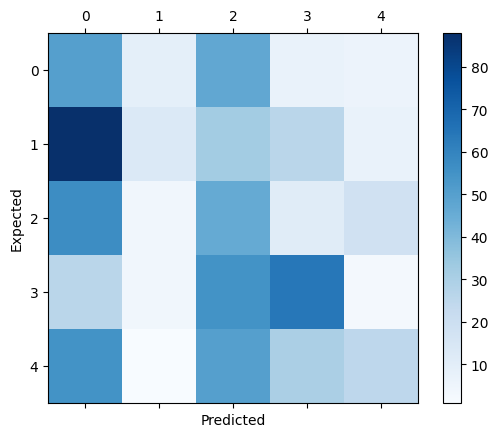

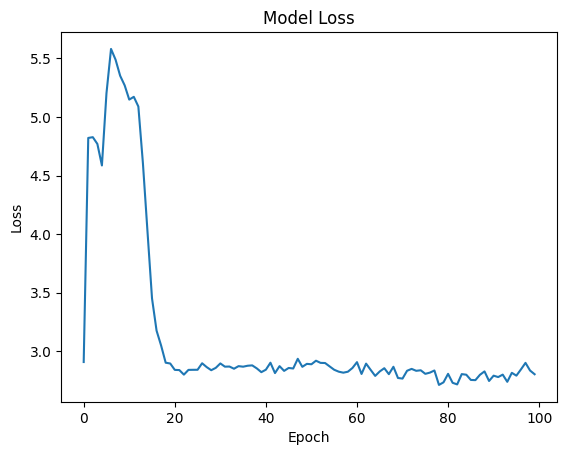

In [9]:
# 性能评估
# 这里需要将预测结果转换为类别标签

print(classification_report(y_test, predictions, target_names=target_labels))
# 绘制混淆矩阵
cm = confusion_matrix(y_test, predictions)
fig, ax = plt.subplots()
cax = ax.matshow(cm, cmap=plt.cm.Blues)
fig.colorbar(cax)
plt.xlabel('Predicted')
plt.ylabel('Expected')
plt.show()

# 绘制损失曲线
plt.plot(bpnn.losses)
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()